In [6]:
import pandas as pd

In [26]:
import numpy as np
from numpy import exp, log

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.ioff()
sns.set()

In [117]:
from functools import partial

In [8]:
df = pd.read_csv('allegations_20200726939.csv')

In [9]:
df.sample(5, random_state = 42)

,unique_mos_id,first_name,last_name,command_now,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
1288,11229,Michal,Jalbrzykowski,090 PCT,40368,9,2018,7,2019,090 PCT,...,32,Black,Male,32.0,Discourtesy,Word,90.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline B)
29399,6004,John,Gogarty,050 DET,9934,9,2005,6,2006,046 PCT,...,45,NaN,NaN,NaN,Discourtesy,Word,46.0,Report-gun possession/shots fired,Arrest - disorderly conduct,Exonerated
26786,36152,Andrew,Valenzano,WARRSEC,17513,2,2009,10,2009,041 PCT,...,34,Hispanic,Male,30.0,Abuse of Authority,Stop,41.0,PD suspected C/V of violation/crime - street,Arrest - other violation/crime,Exonerated
33002,9609,Douglas,Carr,077 DET,8709,1,2005,2,2006,077 PCT,...,31,NaN,NaN,NaN,Abuse of Authority,Question and/or stop,77.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Exonerated
9303,19561,Michael,Greaney,DBQS,21141,7,2010,7,2011,BX IRT,...,25,Hispanic,Male,29.0,Abuse of Authority,Frisk,44.0,PD suspected C/V of violation/crime - street,Summons - other violation/crime,Unsubstantiated


# 1. Complaint Frequency
Note: frequency-0 officers are truncated (do not appear in the dataset)

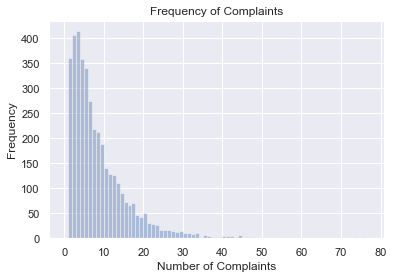

In [10]:
counts = df.unique_mos_id.value_counts()

bins = range(max(counts) + 1 + 2)
fig, ax = plt.subplots()
sns.distplot(counts, norm_hist = False, kde = False, bins = bins, ax = ax)
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Complaints')
plt.show()

## 1a. Zero–Truncated Poisson Distribution

The simplest hypothesis is that every officer has an equal probability of having a complaint lodged against them, per unit time. This would leave to a Poisson distribution with PMF

$$f(k;\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}\$$

However, we do not observe officers with 0 complaints. This leads to a [Zero-Truncated Poisson](https://en.wikipedia.org/wiki/Zero-truncated_Poisson_distribution) distribution with PMF

$$g(k; \lambda) = P_f(k | k > 0) = \frac{f(k; \lambda)}{1 - f(0; \lambda)} = \frac{\lambda^k e^{-\lambda}}{k! ( 1 - e^{-\lambda} )}$$

and MLE $\hat{\lambda}$ satisfying

$$\frac{\hat{\lambda}}{1 - e^{-\lambda}} = \overline{x}$$

Unless $\lambda$ is small, this is close to $\hat{\lambda} = \overline{x}$, the MLE for a regular Poisson distribution.

In [45]:
from scipy.optimize import newton_krylov as newton

class ZeroTruncatedPoisson:

    def __init__(self, lamda = None):
      self.lamda = lamda
      self.data = None
    
    def fit(self, data):
      '''Fit to count data
      
      Parameters
      ----------
      
      Data: a numpy Series with counts
      '''
      
      self.data  = data
      self.x_bar = data.mean()
      self.n     = len(data)
      
      def mle_eqn(lamda):
        return lamda / (1 - exp(-lamda)) - self.x_bar
      
      [self.lamda] = newton(mle_eqn, [self.x_bar])
      
    def is_fit(self):
      return self.data is not None
      
    def log_pmf(self, k):
      terms = (
        [-log(m) for m in range(1, k)] # 1/k!
       +[k * log(self.lamda), - self.lamda, -log(1 - exp(-self.lamda))]
      )
      
      return sum(terms)
      
    def pmf(self, k):
      return exp(self.log_pmf(k))
    
    def log_likelihood(self, data = None):
      '''Log likelihood on a per-observation basis'''
      
      if data is None:
        data = self.data
      
      return self.data.map(lambda count : self.log_pmf(count)).mean()
    
    def plot(self, max_count = None, include_zero = False, normalize = False):
      '''Returns x and y coordinates for plotting the pmf.
      
      Parameters
      ----------
      
      max_count: maximum value of x to return. If None, the maximum
                 value in the datset is used
                 
      include_zero: whether to include 0 in the xs
      
      normalize: whether to return a PMF or expected counts (using
                 the size of the data)
      
      '''        
      if max_count is None:
        max_count = self.data.max()
        
      xs = np.arange(start = 0 if include_zero else 1,
                     stop  = max_count + 1)
      
      pmf = np.vectorize(lambda k : self.pmf(k))
      
      ys = pmf(xs)
      
      if not normalize:
        ys *= self.n
      
      return xs, ys

In [46]:
model = ZeroTruncatedPoisson()
model.fit(counts)

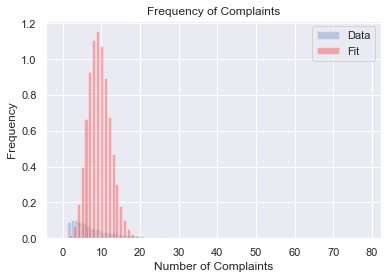

Log Likelihood: -3.002


In [66]:
x_max = max(counts) + 1 + 2
bins = range(x_max)
fig, ax = plt.subplots()
sns.distplot(counts, norm_hist = True, kde = False, bins = bins, ax = ax, hist_kws = {'alpha' : 0.3, 'label' : 'Data'})
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Complaints')

xs, ys = model.plot(max_count = x_max, include_zero = True, normalize = True)

ax.bar(xs, ys, color = 'red', alpha = 0.3, label = 'Fit')
ax.legend();

# It's pretty apparent that the model does not fit the data

plt.show()
print(f'Log Likelihood: {model.log_likelihood():.3f}')

## 1b. The Pareto (Power Law) Distribution

The Pareto Distribution is generated by a process where the "rich get richer" and is the genesis of the "80/20" rule (though the exact numbers may vary) 

In [114]:
from scipy.stats import pareto

In [115]:
b, loc, scale = pareto.fit(counts, floc = 0)
model = pareto(b, loc, scale)
b

0.5756621418416998

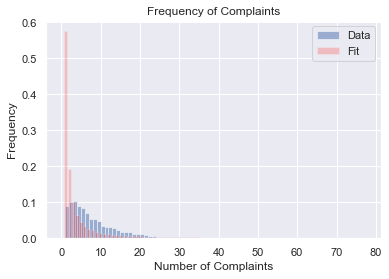

In [116]:
x_max = max(counts) + 1 + 2
bins = range(x_max)
fig, ax = plt.subplots()
sns.distplot(counts, norm_hist = True, kde = False, bins = bins, ax = ax, hist_kws = {'alpha' : 0.5, 'label' : 'Data'})
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Complaints')

xs = np.arange(1, x_max)
ys = model.pdf(xs)

ax.bar(xs, ys, color = 'red', alpha = 0.2, label = 'Fit')
ax.legend();

plt.show()

In [118]:
def pmf(model, k):
  return model.cdf(k+1) - model.cdf(k)

pareto_pmf = partial(pmf, model)
pareto_pmf = np.vectorize(pareto_pmf)

In [ ]:
print(f'{log(pareto_pmf(counts)).mean():.3f}')